<div class="alert alert-success">
    <h1 align="center"> Face Recognition (Triplet Loss)</h1>
    <h2 align="center"> based on proposed lectures by </h2>
    <h3 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h3>
</div>

## Introduction

<h6>Face Recognition:</h6> 
 - Many classes, but very few examples for each class.

## Topics

- Face Recognition
- Siamese Network
- Triplet loss and Contrastive loss
- Defining and implementing our Dataset class.

## Libraries

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from data_utils import create_validation_data

use_gpu = torch.cuda.is_available()

In [4]:
print(use_gpu)

True


Helper methods

In [5]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)


def imshow(img, text=None):  #img: a NumPy array representing an image, text: an optional text annotation to display alongside the image
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

## Data

Here, we will use [Cambridge AT&T Face Dataset](https://www.kaggle.com/kasikrit/att-database-of-faces).
- It contains images from 40 different persons.
- For each person, there are 10 different images.

In [7]:
DATA_DIR = '/mnt/home/mnikzad/ML_Practice/dataset/faces_dataset/'
train_dir = f'{DATA_DIR}train'
valid_dir = f'{DATA_DIR}valid'

sz = 96
batch_size = 16
embed_size = 128
num_epochs = 10

cnn_name = 'resnet50'

## # making validation dataset from the train dataset.

In [10]:
import os
import glob
import shutil
import random
from tqdm import tqdm


if not os.path.exists(valid_dir):
    os.mkdir(valid_dir)
    split=0.20
    train_ds = glob.glob(train_dir + f'/*/*.pgm')
    print(len(train_ds))
        
    valid_sz = int(split * len(train_ds)) if split < 1.0 else split     
    valid_ds = random.sample(train_ds, valid_sz)
    print(len(valid_ds))
        
    for fname in tqdm(valid_ds):
        basename = os.path.basename(fname)
        label = fname.split('/')[-2] #to access the second-to-last element of the lis
        src_folder = os.path.join(train_dir, label)
        tgt_folder = os.path.join(valid_dir, label)
        if not os.path.exists(tgt_folder):
            os.mkdir(tgt_folder)
        shutil.move(os.path.join(src_folder, basename), os.path.join(tgt_folder, basename))
else:
    print("Validation dataset is currently exist.")
    train_ds = glob.glob(train_dir + f'/*/*.pgm')
    print("size of train dataset: ", len(train_ds))
    valid_ds = glob.glob(valid_dir + f'/*/*.pgm')
    print("size of validation dataset: ",len(valid_ds))

Validation dataset is currently exist.
size of train dataset:  320
size of validation dataset:  80


### Dataset

In many problems, we need to define our own Dataset class. To define a new Dataset, you should:

1. Create a subclass of `torch.utils.data.Dataset`
2. Override the following three methods:
 - The constructor or `__init__()`: this method is required to initialize the dataset object.
 - The `__getitem__()` method: this methos enables us to access each training data using its index. In other words, we can use the dataset as a simple list or sequence.
 - The `__len__()` method: this method returns number of data in the dataset.

In [12]:
class TripletNetworkDataset(Dataset):
    
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform or transforms.ToTensor()
        
    def __getitem__(self, index):
        # Select anchor image and its label from dataset
        anchor, anchor_label = self.imgs[index]
        
        # Randomly select a positive and a negative example
        positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label])
        negative = random.choice([img for img, lbl in self.imgs if lbl != anchor_label])
        
        # read the images (anchor, positive and negative images)
        anc_img = Image.open(anchor).convert('RGB')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negative).convert('RGB')
        
        # perform any required transformation (if any)
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        return anc_img, pos_img, neg_img
    
    def __len__(self):
        return len(self.imgs)

#### Training data

In [19]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

face_dataset = datasets.ImageFolder(train_dir)
train_ds = TripletNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=1)

#### Validation data

In [20]:
valid_tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.ToTensor()
])

valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = TripletNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=1)

### Visualize dataset

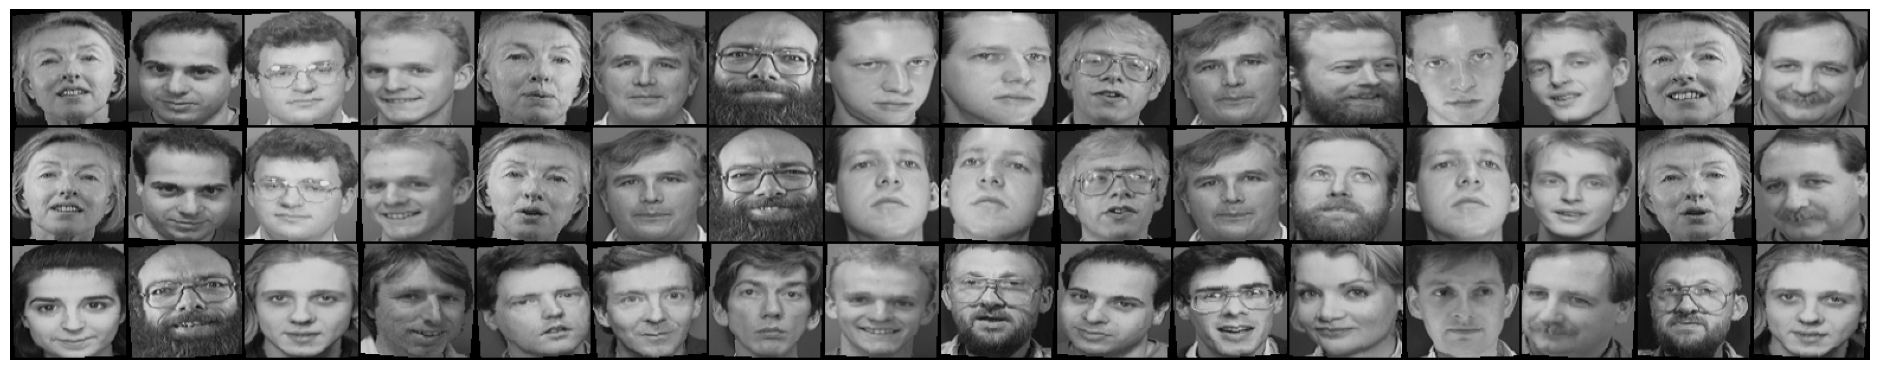

In [25]:
anch_imgs, pos_imgs, neg_imgs = next(iter(train_dl)) #Batch size is 16
concat = torch.cat((anch_imgs, pos_imgs, neg_imgs), 0) #concatenate ancor, positive and negetive images in one culumn
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat, nrow=16))

## Model: Triplet Netwok

In [26]:
class TripletNetwork(nn.Module):
    
    def __init__(self, model, embed_size): #embed_size = 128 is set previously
        super(TripletNetwork, self).__init__()
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),           
            nn.Linear(512, embed_size))
        self.model = model
        
    def forward(self, anc, pos, neg):
        f_anc = self.model(anc)
        f_pos = self.model(pos)
        f_neg = self.model(neg)
        return f_anc, f_pos, f_neg

## Loss: Triplet Loss
Given a triplet $(a, p, n)$, the loss is defined as following:

$$L(a, p, n) = \max (\lVert f(a) - f(p) \rVert^2 - \lVert f(a) - f(n) \rVert^2 + \alpha, 0)$$

In wich:
- $a$ is the anchor image
- $p$ is the positive example, and
- $n$ is the negative example.

Also, $f(.)$ is the vector of features extracted from a CNN (i.e., embedding vector).

In [27]:
class TripletLoss(nn.Module):

    def __init__(self, margin=0.2): #margin is the value of Alpha to avoid always_zero loss value
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, f_anc, f_pos, f_neg):
        pos_distance = F.pairwise_distance(f_anc, f_pos)
        neg_distance = F.pairwise_distance(f_anc, f_neg)
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - \
                                     torch.pow(neg_distance, 2) + self.margin, min=0))
        return loss

## Train

In [28]:
def train_step(model, train_dl, criterion, optimizer, device):
    model.train()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size  #batch_size = 16 is previously set.
    avg_loss = 0.0
    
    for i, (anc, pos, neg) in enumerate(train_dl):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
        
        # forward
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        
        # loss
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.item()) / (i + 1)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
        
    print()

    return model, avg_loss    


def validate_step(model, valid_dl, criterion, device):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    
    with torch.no_grad():
        for i, (anc, pos, neg) in enumerate(valid_dl):
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)

            f_anc, f_pos, f_neg = model(anc, pos, neg)
            loss = criterion(f_anc, f_pos, f_neg)
            avg_loss = (avg_loss * i + loss.item()) / (i + 1)

            # report
            sys.stdout.flush()
            sys.stdout.write("\r Validation Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()
    
    return avg_loss


def train(model, train_dl, valid_dl, criterion, optimizer, device, scheduler=None, num_epochs=10):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}\n--------')
        
        model, train_loss = train_step(model, train_dl, criterion, optimizer, device)
        valid_loss = validate_step(model, valid_dl, criterion, device)
        if scheduler:
            scheduler.step()
            
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
        print()
    loss_history = (train_loss_history, valid_loss_history)
    model.load_state_dict(best_weights)
    return model, best_weights, loss_history

In [30]:
# data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)
 
# model
cnn = get_model(cnn_name) #resnet50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TripletNetwork(cnn, embed_size).to(device)

# loss and optimizer
criterion = TripletLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

## Training

In [31]:
model, best_weights, loss_hist = train(model, 
                                       train_dl, valid_dl, 
                                       criterion, optimizer, 
                                       device,
                                       scheduler, 
                                       num_epochs=num_epochs)

Epoch 1
--------
 Training Step [20/20]: loss 16.09576  
 Validation Step [ 5/ 5]: loss 12.34852  

Epoch 2
--------
 Training Step [20/20]: loss 15.37561  
 Validation Step [ 5/ 5]: loss 7.62010   

Epoch 3
--------
 Training Step [20/20]: loss 11.03375  
 Validation Step [ 5/ 5]: loss 11.61712  

Epoch 4
--------
 Training Step [20/20]: loss 13.11452  
 Validation Step [ 5/ 5]: loss 0.49548  

Epoch 5
--------
 Training Step [20/20]: loss 6.64913  
 Validation Step [ 5/ 5]: loss 1.32420  

Epoch 6
--------
 Training Step [20/20]: loss 5.17502  
 Validation Step [ 5/ 5]: loss 4.31431  

Epoch 7
--------
 Training Step [20/20]: loss 3.79908   
 Validation Step [ 5/ 5]: loss 0.73064  

Epoch 8
--------
 Training Step [20/20]: loss 4.75539   
 Validation Step [ 5/ 5]: loss 1.37261  

Epoch 9
--------
 Training Step [20/20]: loss 1.98164  
 Validation Step [ 5/ 5]: loss 0.00000  

Epoch 10
--------
 Training Step [20/20]: loss 1.88629  
 Validation Step [ 5/ 5]: loss 0.95926  



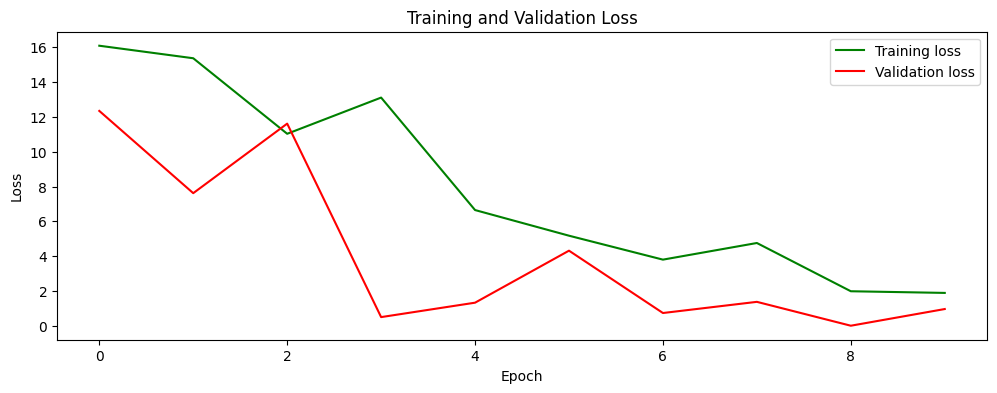

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

## Testing

In [33]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

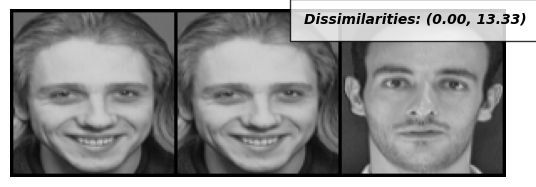

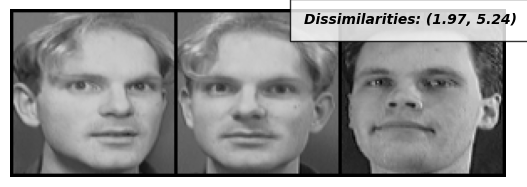

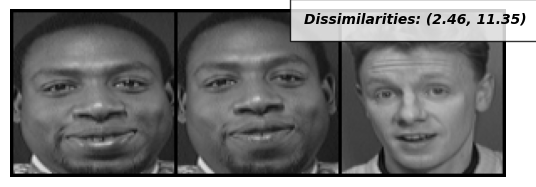

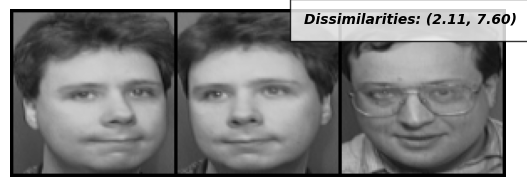

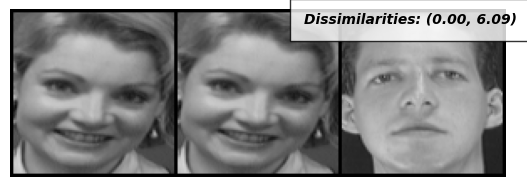

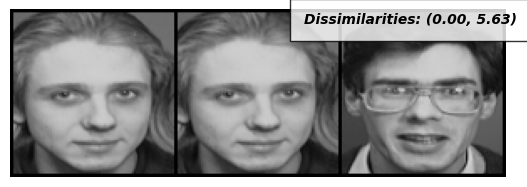

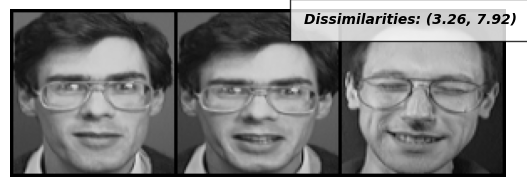

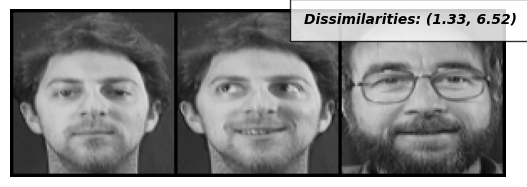

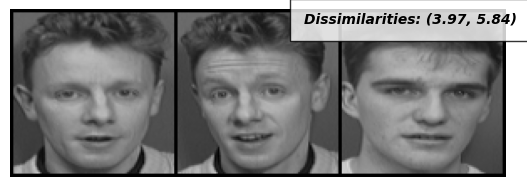

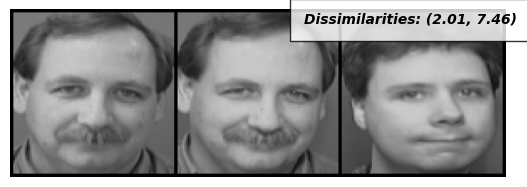

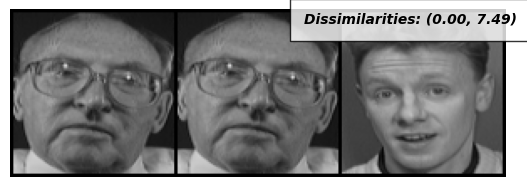

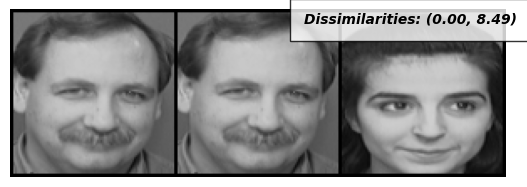

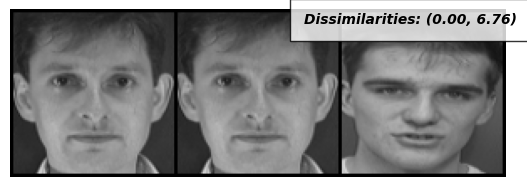

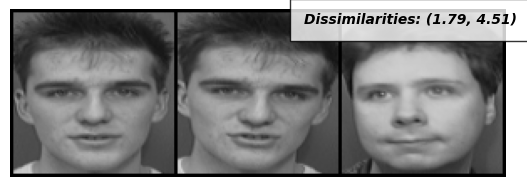

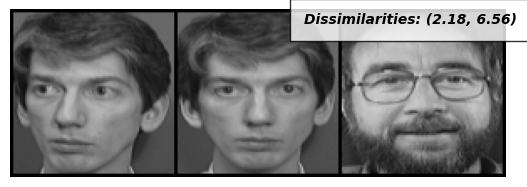

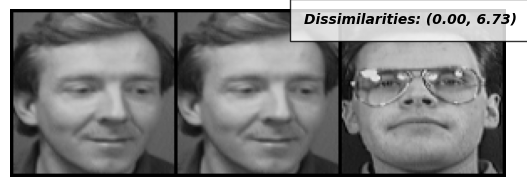

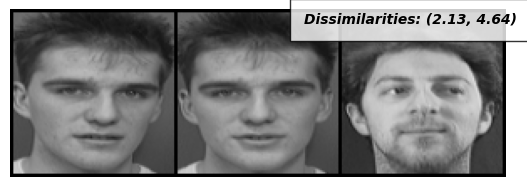

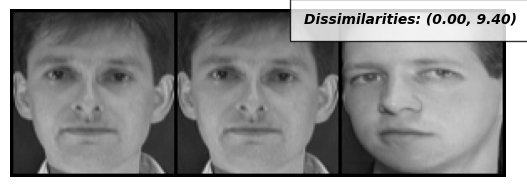

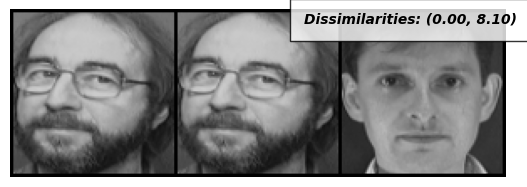

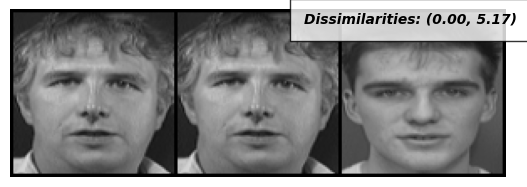

In [34]:
model.eval()

dataiter = iter(valid_dl)

with torch.no_grad():
    for i in range(20):
        x0, x1, x2 = next(dataiter)
        concat = torch.cat((x0, x1, x2), 0)
        f0, f1, f2 = model(x0.to(device), x1.to(device), x2.to(device))
        pos_distance = F.pairwise_distance(f0, f1)
        neg_distance = F.pairwise_distance(f0, f2)
        imshow(torchvision.utils.make_grid(concat), f'Dissimilarities: ({pos_distance.item():.2f}, {neg_distance.item():.2f})')